In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Set the path for the dataset folder in Google Drive
drive_path = '/content/drive/MyDrive/dataset/'

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/dataset/training2017-20240215T030806Z-001.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(drive_path)

# List the files in the extracted folder
extracted_files = os.listdir(drive_path)
print(f"Files extracted to {drive_path}: {extracted_files}")


Files extracted to /content/drive/MyDrive/dataset/: ['training2017-20240215T030806Z-001.zip', 'data_second.csv', 'new3rd.csv', 'training2017']


In [ ]:
number_of_classes = 4

In [ ]:
def discritize(x):
    answer = np.zeros((np.shape(x)[0]))
    for i in range(np.shape(x)[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(np.int)

In [ ]:
mypath = '/content/drive/MyDrive/dataset/training2017/'
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f[0] == 'A')]
bats = [f for f in onlyfiles if f[7] == 'm']
mats = [f for f in bats if (np.shape(sio.loadmat(mypath + f)['val'])[1] >= 9000)]
SampleSize = np.shape(sio.loadmat(mypath + mats[0])['val'])[1]

SampleSize


9000

In [ ]:
SampleSize = 9000

In [ ]:
from sklearn.utils import shuffle
from sklearn.utils import resample

Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
df_1 = Train_data[Train_data[1]=='A']
df_2 = Train_data[Train_data[1]=='N']
df_3 = Train_data[Train_data[1]=='O']
df_4 = Train_data[Train_data[1]=='~']

df_1_upsample = resample(df_1, replace=True, n_samples=5500, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=5500, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=5500, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=8500, random_state=126)

training_data = pd.concat([df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])
TrainDataSuffled = shuffle(training_data)

In [ ]:
FileList = list(TrainDataSuffled[0] + '.mat')
#len(FileList)

In [ ]:
print(df_1.shape, df_2.shape, df_3.shape, df_4.shape)

(738, 2) (5050, 2) (2456, 2) (284, 2)


In [ ]:
DelRows = []
for i in range(len(FileList)):
  #print(i)
  if (sio.loadmat(mypath + FileList[i])['val']).shape[1]<9000:
    DelRows.append(FileList[i])

len(DelRows)

5939

In [ ]:
for j in range(len(DelRows)):
  TrainDataSuffled.drop(TrainDataSuffled.loc[TrainDataSuffled[0] == DelRows[j][0:6]].index, inplace = True)

NewFileList = list(TrainDataSuffled[0]+'.mat')
len(NewFileList)

19061

In [ ]:
len(NewFileList)

19061

In [ ]:
X = np.zeros((len(NewFileList), SampleSize))
for i in range(len(NewFileList)):
    X[i, :] = sio.loadmat(mypath + NewFileList[i])['val'][0, :9000]
    #print(i)

In [ ]:
X.shape

(19061, 9000)

In [ ]:
len(NewFileList), TrainDataSuffled.shape[0]

(19061, 19061)

In [ ]:
target_train = np.zeros((len(NewFileList), 1))
#TrainDataSuffled  NewFileList
#Train_data = pd.read_csv(mypath + 'REFERENCE.csv', sep=',', header=None, names=None)
for i in range(len(NewFileList)):
    if Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'N':
        target_train[i] = 0
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'A':
        target_train[i] = 1
    elif Train_data.loc[Train_data[0] == NewFileList[i][:6], 1].values == 'O':
        target_train[i] = 2
    else:
        target_train[i] = 3

In [ ]:
number_of_classes = 4

In [ ]:
Label_set = np.zeros((len(NewFileList), number_of_classes))
for i in range(np.shape(target_train)[0]):
    dummy = np.zeros((number_of_classes))
    dummy[int(target_train[i])] = 1
    Label_set[i, :] = dummy

<ipython-input-86-804af812e2c2>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[int(target_train[i])] = 1


In [ ]:
train_len = 0.8 #0.75
X_train = X[:int(train_len*len(NewFileList)), :]
Y_train = Label_set[:int(train_len*len(NewFileList)), :]
X_val = X[int(train_len*len(NewFileList)):, :]
Y_val = Label_set[int(train_len*len(NewFileList)):, :]

In [ ]:
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = numpy.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
print(X_train.shape, X_val.shape, SampleSize)

(15248, 1, 9000) (3813, 1, 9000) 9000


In [ ]:
sum(Y_train)

array([3947., 3787., 4021., 3493.])

In [ ]:
sum(Y_val)

array([ 980.,  913., 1056.,  864.])

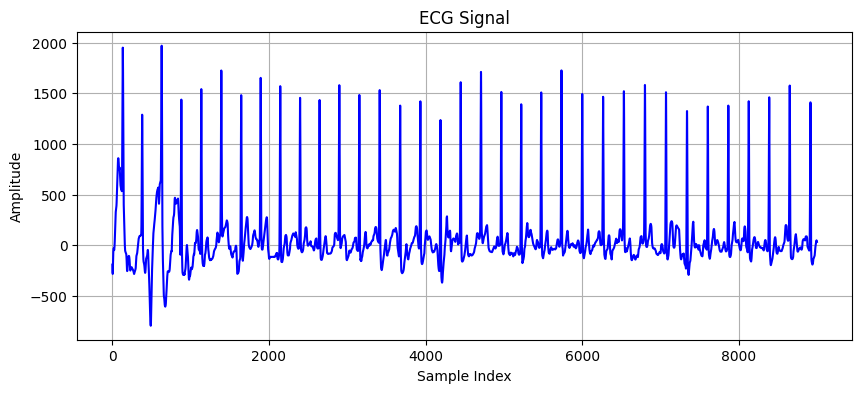

In [ ]:
import matplotlib.pyplot as plt

# Load the array
ecg_data = sio.loadmat(mypath + NewFileList[1])['val']

# Plot the ECG signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_data.ravel(), color='blue')
plt.title('ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



In [ ]:
# Get the filename of the sample
filename = NewFileList[1]

# Extract the prefix to match with the labels
prefix = filename[:6]

# Find the index corresponding to the prefix in the original file list
index = [i for i, file in enumerate(TrainDataSuffled[0]) if file.startswith(prefix)][0]

# Get the label from target_train at the corresponding index
label = target_train[index]

print("Label assigned to the sample:", label)


Label assigned to the sample: [0.]


In [ ]:
# Deep BiLSTM Model
batch_size = 64
x_train = X_train,
y_train = Y_train
x_val = X_val,
y_val = Y_val

model = Sequential()
model.add(Bidirectional(LSTM(1024, return_sequences=True), input_shape=(1, SampleSize)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))

model.add(Bidirectional(LSTM(64)))
#model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())

#output layer
model.add(Dense(number_of_classes, activation='softmax'))

initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# old version
'''
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
adam = keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
adam = Adam(learning_rate=0.00001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) #categorical_crossentropy
'''
# end

"\nearly_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')\nadam = keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)\nadam = Adam(learning_rate=0.00001)\n\nmodel.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) #categorical_crossentropy\n"

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 2048)           82124800  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 2048)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 1024)           10489856  
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1, 1024)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 512)            2623488   
 onal)                                                           
                                                        

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 bidirectional (Bidirection  (None, 1, 2048)           82124800  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 2048)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1, 1024)           10489856  
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1, 1024)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 512)            2623488   
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 1, 256)            656384    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
=================================================================
Total params: 96069348 (366.48 MB)
Trainable params: 96069348 (366.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [ ]:
history = model.fit(x_train, y_train, epochs=40, batch_size=batch_size,
                    validation_data=(x_val, y_val), verbose=2, shuffle=False,
                    callbacks=[early_stopping])
# model.save('Keras_models/LSTM_ECG_Model_' + str(i) + '_' + str(j) + '_' + str() + '.h5')
predictions = model.predict(x_val)

Epoch 1/40
239/239 - 40s - loss: 1.3858 - accuracy: 0.2991 - val_loss: 1.3847 - val_accuracy: 0.3965 - 40s/epoch - 167ms/step
Epoch 2/40
239/239 - 17s - loss: 1.3830 - accuracy: 0.4084 - val_loss: 1.3789 - val_accuracy: 0.5867 - 17s/epoch - 72ms/step
Epoch 3/40
239/239 - 16s - loss: 1.3703 - accuracy: 0.6373 - val_loss: 1.3554 - val_accuracy: 0.6861 - 16s/epoch - 66ms/step
Epoch 4/40
239/239 - 16s - loss: 1.3155 - accuracy: 0.6888 - val_loss: 1.2370 - val_accuracy: 0.6667 - 16s/epoch - 67ms/step
Epoch 5/40
239/239 - 16s - loss: 1.0017 - accuracy: 0.6371 - val_loss: 0.7885 - val_accuracy: 0.6696 - 16s/epoch - 66ms/step
Epoch 6/40
239/239 - 16s - loss: 0.6610 - accuracy: 0.7345 - val_loss: 0.5626 - val_accuracy: 0.7784 - 16s/epoch - 69ms/step
Epoch 7/40
239/239 - 18s - loss: 0.4552 - accuracy: 0.8145 - val_loss: 0.4092 - val_accuracy: 0.8447 - 18s/epoch - 74ms/step
Epoch 8/40
239/239 - 16s - loss: 0.3310 - accuracy: 0.8915 - val_loss: 0.3080 - val_accuracy: 0.8946 - 16s/epoch - 66ms/step

In [ ]:
from keras.models import load_model
# Save the model
model.save('/content/drive/MyDrive/dataset/ecg_model_40_ephos.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
'''
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
Y_actual = discritize(y_val)
Y_predict = discritize(predictions)

Accuracy = accuracy_score(Y_actual, Y_predict)
Precision = precision_score(Y_actual, Y_predict, average='weighted')
Recall = recall_score(Y_actual, Y_predict, average='weighted')
F1score = f1_score(Y_actual, Y_predict, average='weighted')

print(Accuracy, Precision, Recall, F1score)
'''

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming discritize is a function that converts continuous/probability predictions to discrete classes
def discritize(predictions, threshold=0.5):
    #return np.argmax(predictions, axis=1)
    return np.array([[1 if pred >= threshold else 0 for pred in row] for row in predictions])

# Assuming y_val and predictions are available
Y_actual = discritize(y_val)
Y_predict = discritize(predictions)

print(Y_actual)
print(Y_predict)

# Calculate classification metrics
Accuracy = accuracy_score(Y_actual, Y_predict)
Precision = precision_score(Y_actual, Y_predict, average='weighted')
Recall = recall_score(Y_actual, Y_predict, average='weighted')
F1score = f1_score(Y_actual, Y_predict, average='weighted')

# Print the metrics
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1 Score:", F1score)

[[0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]]
[[0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 ...
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]]
Accuracy: 0.9386309992132179
Precision: 0.9402623079442567
Recall: 0.9386309992132179
F1 Score: 0.939435320217654


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


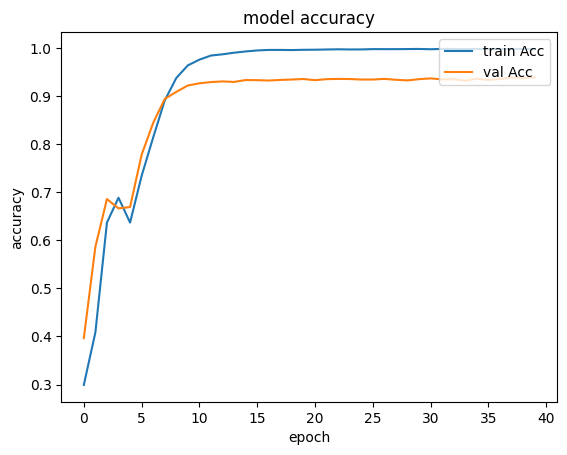

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train Acc', 'val Acc'], loc='upper right')
plt.show()

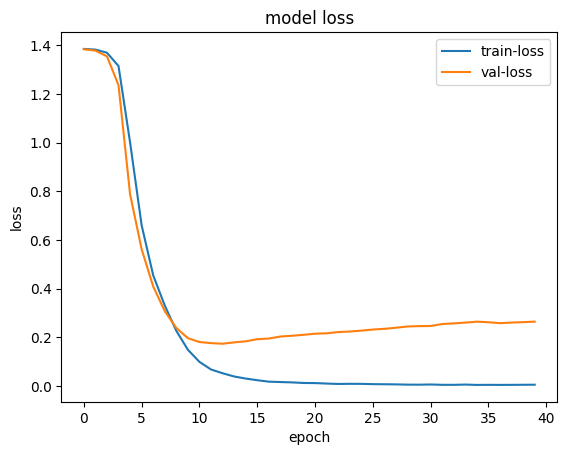

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(X_val)
predictions

120/120 [==============================] - 6s 17ms/step


array([[3.90475529e-04, 7.74015740e-10, 9.99609411e-01, 1.38104738e-07],
       [1.08281147e-05, 2.14048978e-05, 2.08801412e-05, 9.99946952e-01],
       [9.17547266e-04, 4.92052088e-09, 9.99081850e-01, 5.38032566e-07],
       ...,
       [2.43560993e-04, 2.11508533e-10, 9.99756396e-01, 5.18150785e-08],
       [9.99653578e-01, 1.12229114e-04, 2.34170482e-04, 9.39674560e-10],
       [8.52213088e-06, 1.70298081e-05, 1.66524405e-05, 9.99957800e-01]],
      dtype=float32)

In [ ]:
Y_val, Y_predict

(array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]]),
 array([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]]))

In [ ]:
out = pd.read_csv('/content/drive/MyDrive/dataset/data_second.csv')
out.shape




(13604, 1)

In [ ]:
out=np.array(out)
out=out.reshape(1,13604)

In [ ]:
out=out[:,0:9000]

In [ ]:
out=out.reshape(1,1,9000)

In [ ]:
pre=model.predict(out)

1/1 [==============================] - 0s 33ms/step


In [ ]:
pre.argmax()


0

In [ ]:
out = pd.read_csv('/content/drive/MyDrive/dataset/new3rd.csv')
out.shape

(10872, 1)

In [ ]:
out=np.array(out)
out=out.reshape(1,10872)

In [ ]:
out=out[:,0:9000]

In [ ]:
out=out.reshape(1,1,9000)

In [ ]:
pre=model.predict(out)

1/1 [==============================] - 0s 22ms/step


In [ ]:
pre.argmax()

0

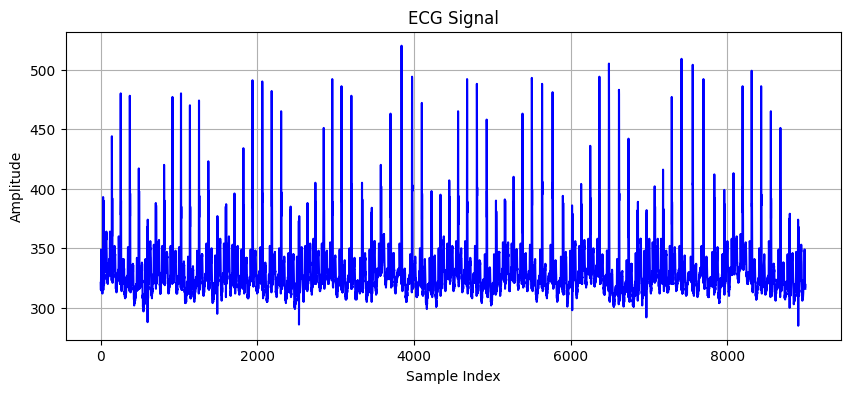

In [ ]:
import matplotlib.pyplot as plt

# Load the array
ecg_data_1 = out

# Plot the ECG signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_data_1.ravel(), color='blue')
plt.title('ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

120/120 [==============================] - 2s 18ms/step


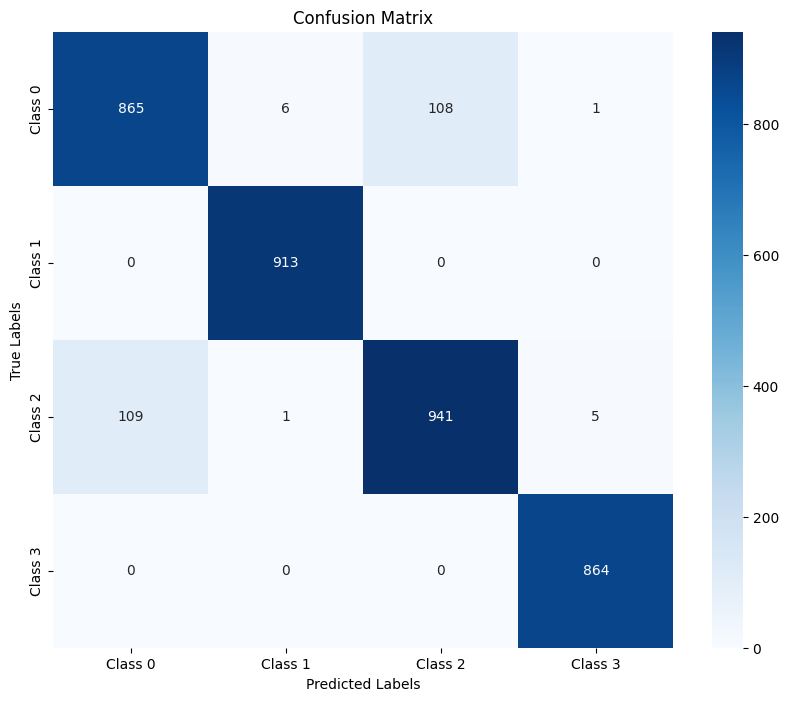

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions using the trained model
predictions = model.predict(X_val)

# Convert one-hot encoded labels to class indices for predictions and actual labels
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
x_val_1 = np.array(X_val)
x_val_1.shape

(3813, 1, 9000)